In [23]:
import pandas as pd
import string
import nltk

### Mise en forme des caractéres : tout en minuscule, suppression de la ponctuation et des chiffres 

In [24]:
df = pd.read_csv("Emotion_final.csv")
df = df.apply(lambda x: x.astype(str).str.lower())
df['Text'] = df['Text'].str.replace('[{}\d]'.format(string.punctuation), '', regex=True)

In [25]:
df

,Text,Emotion
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger
...,...,...
21454,melissa stared at her friend in dism,fear
21455,successive state elections have seen the gover...,fear
21456,vincent was irritated but not dismay,fear
21457,kendallhume turned back to face the dismayed coup,fear


In [26]:
df.describe()

,Text,Emotion
count,21459,21459
unique,21405,6
top,i feel so tortured by it,happy
freq,2,7029


### Suppression des doublons

In [27]:
dup = df.duplicated()
dup.value_counts()

False    21456
True         3
dtype: int64

In [28]:
df = df.drop_duplicates(keep='last')

In [29]:
df.Emotion.unique()

array(['sadness', 'anger', 'love', 'surprise', 'fear', 'happy'],
      dtype=object)

In [30]:
df.Emotion.value_counts()

happy       7028
sadness     6265
anger       2992
fear        2651
love        1641
surprise     879
Name: Emotion, dtype: int64

In [31]:
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/apprenant/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### Stopwords

In [32]:
stops = set(stopwords.words('english'))
nv_mots_stops = ['feel', 'feeling','feelings', 'look', 'days','life','like','im','really', 'see', 'life', 'today','didnt','go', 'know', 'get', 'want', 'would', 'time', 'little', 'ive', 'still', 'even', 'one',  'people', 'think', 'bit', 'things', 'much', 'dont', 'make', 'day', 'something', 'back', 'going', 'way', 'could']
stops.update(nv_mots_stops)

### Les 30 mots les plus frequents par sentiments

In [33]:
def top_30_mots(texts, n=30):
    mots = []
    for text in texts:
        for mot in text.split():
            if mot.isalpha() and mot not in stops:
                mots.append(mot)
    mot_freq = {mot: mots.count(mot) for mot in set(mots)}
    top_mots = sorted(mot_freq.items(), key=lambda x: x[1], reverse=True)[:n]
    return top_mots

sentiments = ['sadness', 'anger', 'love', 'surprise', 'fear', 'happy']

top_mots_par_sentiment = {}

for sentiment in sentiments:
    texts = df[df['Emotion'] == sentiment]['Text']
    top_mots = top_30_mots(texts)
    top_mots_par_sentiment[sentiment] = top_mots



In [34]:
top_mots_par_sentiment["sadness"]

[('pretty', 146),
 ('right', 143),
 ('always', 141),
 ('love', 138),
 ('felt', 136),
 ('cant', 132),
 ('sad', 130),
 ('alone', 127),
 ('bad', 126),
 ('say', 125),
 ('made', 124),
 ('depressed', 123),
 ('work', 121),
 ('need', 121),
 ('good', 121),
 ('never', 111),
 ('miserable', 108),
 ('though', 104),
 ('lost', 101),
 ('kind', 101),
 ('also', 100),
 ('last', 99),
 ('left', 99),
 ('feels', 99),
 ('home', 99),
 ('many', 98),
 ('help', 98),
 ('sorry', 97),
 ('stupid', 95),
 ('guilty', 95)]

### HeatMap des mots les plus frequents par sentiment

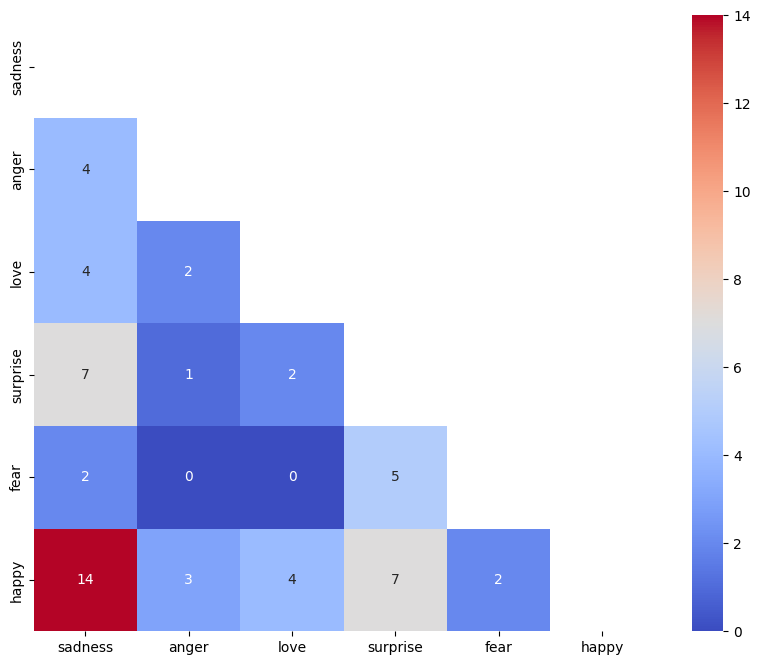

In [35]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

matrice = pd.DataFrame(index=sentiments, columns=sentiments)

for sentiment1 in sentiments:
    for sentiment2 in sentiments:
        mots1 = set(mot for mot, _ in top_mots_par_sentiment[sentiment1])
        mots2 = set(mot for mot, _ in top_mots_par_sentiment[sentiment2])
        mots_commmun = len(mots1 & mots2)
        matrice.loc[sentiment1, sentiment2] = mots_commmun

matrice = matrice.astype(int)   

mask = np.triu(np.ones_like(matrice, dtype=bool))

plt.figure(figsize=(10, 8))
sns.heatmap(matrice, annot=True, cmap='coolwarm', mask=mask)
plt.show()


    Pour chaque sentiment on calcule le nombre de mots en commun entre les 30 mots les plus fréquents en convertissant les listes de mots en ensemble. Ensuite on compte les mots qui apparaissent dans les deux set. Le nombre de mots en commun est ensuite affiché dans la matrice

### Creation de deux modéle 
- bow avec LogisticRegression

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

nltk.download('punkt')
nltk.download('wordnet')

stops = list(stops)

lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    return ' '.join(lemmatizer.lemmatize(term) for term in word_tokenize(text.lower()) if term not in stops)

X = df['Text'].apply(preprocess_text)
y = df['Emotion']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

pipeline = Pipeline([
    ('bow', CountVectorizer(stop_words=stops)),
    ('clf', LogisticRegression(C=20.52695741523762, max_iter=186, solver='saga', penalty='l1')),
])

pipeline.fit(X_train, y_train)

preds = pipeline.predict(X_test)

print("Accuracy: ", accuracy_score(y_test, preds).round(2))

- TFIDF avec RandomForestClassifier  

In [39]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
import joblib

nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

stops = list(stops)

lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    return ' '.join(lemmatizer.lemmatize(term) for term in word_tokenize(text.lower()) if term not in stops)

X = df['Text'].apply(preprocess_text)
y = df['Emotion']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words=stops)),
    ('clf', RandomForestClassifier()),
])

pipeline.fit(X_train, y_train)

preds = pipeline.predict(X_test)

print("Accuracy: ", accuracy_score(y_test, preds).round(2))

joblib.dump(pipeline, 'model_tfidf.joblib')

[nltk_data] Downloading package punkt to /home/apprenant/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/apprenant/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/apprenant/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Accuracy:  0.89


['model_tfidf.joblib']

## Stocker les données avec ElasticSearch

### Mise en place

- docker run -d -p 9200:9200 -v /usr/share/elasticsearch/data -e "discovery.type=single-node" --name elastic docker.elastic.co/elasticsearch/elasticsearch:7.17.10
- docker logs elastic
- curl http://localhost:9200/


### Mapper et importer les données 

In [43]:
from datetime import datetime
from faker import Faker
from elasticsearch import Elasticsearch

model = joblib.load('model_tfidf.joblib')

fake = Faker()
es = Elasticsearch(hosts=["http://localhost:9200"])

mapping = {
    "mappings": {
        "properties": {
            "patient_lastname": {"type": "keyword"},
            "patient_firstname": {"type": "keyword"},
            "text": {"type": "text", "analyzer": "standard"},
            "date": {"type": "date"},
            "patient_left": {"type": "boolean"},
            "emotion": {"type": "keyword"},
            "confidence": {"type": "float"}
        }
    }
}

es.indices.create(index="notes", body=mapping)

for _ in range(21456):
    patient_lastname = fake.last_name()
    patient_firstname = fake.first_name()
    text = fake.text()
    date = fake.date_between(start_date='-1y', end_date='today')
    patient_left = fake.boolean()
    
    processed_text = preprocess_text(text)
    
    emotion = model.predict([processed_text])[0]
    confidence = model.predict_proba([processed_text])[0].max()
    
    document = {
        "patient_lastname": patient_lastname,
        "patient_firstname": patient_firstname,
        "text": text,
        "date": date,
        "patient_left": patient_left,
        "emotion": emotion,
        "confidence": confidence
    }
    
    es.index(index="notes", body=document)


/tmp/ipykernel_26129/1012831758.py:31: DeprecationWarning: The 'body' parameter is deprecated and will be removed in a future version. Instead use individual parameters.
  es.indices.create(index="notes", body=mapping)
/tmp/ipykernel_26129/1012831758.py:31: ElasticsearchWarning: Elasticsearch built-in security features are not enabled. Without authentication, your cluster could be accessible to anyone. See https://www.elastic.co/guide/en/elasticsearch/reference/7.17/security-minimal-setup.html to enable security.
  es.indices.create(index="notes", body=mapping)
/tmp/ipykernel_26129/1012831758.py:61: DeprecationWarning: The 'body' parameter is deprecated and will be removed in a future version. Instead use the 'document' parameter. See https://github.com/elastic/elasticsearch-py/issues/1698 for more information
  es.index(index="notes", body=document)
/tmp/ipykernel_26129/1012831758.py:61: ElasticsearchWarning: Elasticsearch built-in security features are not enabled. Without authentica